## DCP Internship
#### Reading in SafeGraph Data
##### Part 1: Quantifying/Determining sample bias in NYC only
    - NOTE: this is using the safegraph python notebook as a reference. Credit to SafeGraph

In [ ]:
os.getcwd()

In [1]:
# make wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:88% !important; }</style>"))

In [2]:
#reading in relevant libs
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import s3fs
import os
import time

In [3]:
from safegraph_py_functions import safegraph_py_functions as sgpy
#from geo import stco, sub

In [4]:
#ensuring sgpy works
sgpy.test_me()

Hello World


In [5]:
# allow max rows and colums to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# read in CBG for join
cbg_nyc = pd.read_csv('filepath.csv')
cbg_nyc.head()
# read in geowalk for join
geowalk = pd.read_csv(f'filepath.csv')
geowalk.head(5)

,Pop_10E,orig_st,orig_co,orig_cbg,orig_ctract,orig_nta,orig_puma,orig_subbor,orig_stco
0,0,36,5,360050001000,36005000100,BX98,3603710,36005CS,36005
1,11091,36,5,360050001001,36005000100,BX98,3603710,36005CS,36005
2,0,36,5,360050002000,36005000200,BX09,3603709,36005CS,36005
3,1120,36,5,360050002001,36005000200,BX09,3603709,36005CS,36005
4,1974,36,5,360050002002,36005000200,BX09,3603709,36005CS,36005


In [125]:
# read in the Neighborhood names for NTA codes
NTA_names = pd.read_csv(f'Neighborhoods.csv')
NTA_names
NTA_names['Name'] = NTA_names['Name'].str.replace('-',' ') # replace - value with space
NTA_names = NTA_names.rename({'NTA \nCode':'code', 'Name':'name'}, axis = 1) # rename columns
NTA_names = NTA_names.drop_duplicates(subset = ['code'])
len(NTA_names)

195

In [6]:
# Specifying SafeGraph keys --
myAccessKey = 'ACCESS KEY here'
mySecretKey = 'SECRET KEY here'
fs = s3fs.S3FileSystem(key=myAccessKey, secret=mySecretKey, client_kwargs={'endpoint_url': 'https://s3.wasabisys.com', 'region_name':'us-east-1'})

In [178]:
y1, y2 = '2019', '2020'
jan, feb, mar, apr, may, jun = '01','02','03','04','05','06'
# define months/days
# for iterating through all 
monthList =["01","02","03","04","05","06", "07","08"]
dayNumList =[31, 29, 31, 30, 31, 30, 31, 31]
years = ["2019","2020"]
dayList =["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24","25","26","27","28","29","30","31"]

#### View Tuesday March 3, 2020, pre CoVID lockdown
#### Then, check Tuesday February 4th 2020, pre CoVID lockdown
___________________________________________________________________
WEEKLY LOCKDOWN (first sunday - saturday from Janary - June 2020)
- Jan - 5th to 11th
- Feb - 2nd to 8th
- Mar - 1st to 7th 
- Apr - 5th to 11th
- May - 3rd to 9th
- Jun - 7th to 13th

In [177]:

# first looking at January
frames = []
for i in range(4,11):
    with fs.open(f'sg-c19-response/social-distancing/v2/{y2}/{jan}/{dayList[i]}/{y2}-{jan}-{dayList[i]}-social-distancing.csv.gz','rb') as file:
        print(f'{jan}-{dayList[i]}')
        # read SG's file
        df = pd.read_csv(file, escapechar='\\', compression='gzip')
        # filter NYC's Origin CBGs
        df_2 = pd.merge(geowalk, df, left_on="orig_cbg", right_on="origin_census_block_group", how="inner")
        frames.append(df_2)

01-05
01-06
01-07
01-08
01-09
01-10
01-11


In [179]:
df = pd.concat(frames)

In [199]:
# view join
len(df)

43878

In [181]:
# create objects aggregated from NTA + PUMA + BORO
# needs alteration due to looking at a rolling week, not single day.
# aggregate population by the NTA code
nta_geo = df.groupby(['orig_nta'], as_index = False
                         ).agg(
                            {'Pop_10E': 'sum',
                             'device_count':'sum',
                             'candidate_device_count':'sum',
                             'orig_cbg':'count'}) # add census block group counts.
# aggregate population by PUMA code
puma_geo = df.groupby(['orig_puma'], as_index = False
                         ).agg(
                            {'Pop_10E': 'sum',
                             'device_count':'sum',
                             'candidate_device_count':'sum',
                             'orig_cbg':'count'}) # add census block group counts.
# aggregate population by boro #
boro_geo = df.groupby(['orig_co'], as_index = False
                         ).agg(
                            {'Pop_10E': 'sum',
                             'device_count':'sum',
                             'candidate_device_count':'sum',
                             'orig_cbg':'count'}) # add census block group counts.

In [182]:
print('Number of Neighborhoods: ',len(nta_geo))
nta_geo = pd.merge(nta_geo, NTA_names, how = 'left', left_on = 'orig_nta', right_on = 'code')
nta_geo.head(5)

Number of Neighborhoods:  195


,orig_nta,Pop_10E,device_count,candidate_device_count,orig_cbg,code,name
0,BK09,160209,4724,10570,133,BK09,Brooklyn Heights Cobble Hill
1,BK17,451626,29492,51261,357,BK17,Sheepshead Bay Gerritsen Beach Manhattan Beach
2,BK19,248829,16060,29414,182,BK19,Brighton Beach
3,BK21,223755,12694,27143,192,BK21,Seagate Coney Island
4,BK23,124250,7095,11557,63,BK23,West Brighton


In [183]:
nta_geo = nta_geo.drop(['code'], axis = 1)
nta_geo

,orig_nta,Pop_10E,device_count,candidate_device_count,orig_cbg,name
0,BK09,160209,4724,10570,133,Brooklyn Heights Cobble Hill
1,BK17,451626,29492,51261,357,Sheepshead Bay Gerritsen Beach Manhattan Beach
2,BK19,248829,16060,29414,182,Brighton Beach
3,BK21,223755,12694,27143,192,Seagate Coney Island
4,BK23,124250,7095,11557,63,West Brighton
5,BK25,310212,17172,29834,273,Homecrest
6,BK26,206052,12666,24171,140,Gravesend
7,BK27,209517,13105,23072,182,Bath Beach
8,BK28,621089,33813,61215,483,Bensonhurst West
9,BK29,440846,24808,42525,343,Bensonhurst East


In [184]:
print('Number of PUMAs: ',len(puma_geo))
puma_geo.head(10)

Number of PUMAs:  55


,orig_puma,Pop_10E,device_count,candidate_device_count,orig_cbg
0,3603701,756096,29131,60630,645
1,3603702,968413,46230,101778,937
2,3603703,804041,35920,70465,626
3,3603704,866348,39954,86051,763
4,3603705,1129604,58781,142590,868
5,3603706,891835,39055,85078,735
6,3603707,939799,40151,91441,742
7,3603708,975051,42286,104006,728
8,3603709,1269672,58839,126123,1072
9,3603710,1092601,50667,119893,823


In [185]:
print('Number of Boros: ',len(boro_geo))
b_name = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
boro_geo['b_name'] = b_name
boro_geo.head()

Number of Boros:  5


,orig_co,Pop_10E,device_count,candidate_device_count,orig_cbg,b_name
0,5,9693460,441014,988055,7939,Bronx
1,47,17420328,801929,1647728,14223,Brooklyn
2,61,11101050,432285,1049023,7711,Manhattan
3,81,15614178,778112,1542032,11858,Queens
4,85,3280893,226027,391074,2147,Staten Island


### Quantifying sampling bias by geographies
    - Bias = observed_proportion − expected_proportion

In [163]:
# functions, with help of safegraph to compute bias & plot sg vs geographies
# CREDIT to safegraph for graphing functions
def compute_bias(df, sample_col = 'candidate_device_count', pop_col = 'Pop_10E'):
    obs_proportion = df[sample_col]/df[sample_col].sum()*100 # take one record's candidate devices, divide by total devices within dataset
    exp_proportion = df[pop_col]/df[pop_col].sum()*100       # take one record's population, divide by total population of dataset 
    bias = obs_proportion - exp_proportion # candidate proportion - the population proportion
    return(bias) # return bias value for each record

def make_center_line_coords(df,x,y):
  # This creates two coords to define the hypothetical line in which x and y are perfectly correlatd
    expected_slope = df[y].sum()/df[x].sum()
    xcoord = np.array([df[x].min(), df[x].max()])
    ycoord = expected_slope*xcoord
    return((xcoord,ycoord))
  
def summarize_bias(df,bias_col):
    sum_abs_bias = np.absolute(df[bias_col]).sum()
    print("Sum Absolute Bias: {0:.2f}".format(sum_abs_bias))
    return(None)

def plot_sg_vs_geos(df, xvar, yvar,bias_col='bias',xlim_=None,ylim_=None,text_col=None, num_to_label=5,alpha=0.9,labelfontsize=14):
  # `text_col` is the column used to annotate the points
  # `num_to_label` sets the top num_to_label records sorted by yvar to be annotated
    plt.rcParams['figure.figsize'] = [11, 9]
        
     # Report Stats
    pearson_r = df.corr().loc[xvar, yvar]
    print("pearson r: {0:.3f}".format(pearson_r))
    summarize_bias(df,bias_col)
  # scatter plot
    ax = df.plot.scatter(xvar, yvar, alpha = alpha, edgecolor = 'blue', xlim = xlim_, ylim = ylim_)
  # annotate 
    xadj = df[xvar].max()*0.02
    if(text_col is not None):
        for i, point in df.sort_values(by=xvar,ascending=False).iloc[0:num_to_label].iterrows():
            ax.text(point[xvar] + xadj, point[yvar], str(point[text_col]),fontsize=labelfontsize, verticalalignment='bottom')
  # plot expectation line
    line_coords = make_center_line_coords(df,xvar,yvar)
    plt.plot(line_coords[0],line_coords[1], color = 'red',linestyle='-', linewidth=1)
    return(ax)


In [164]:
# NTA sampling bias
df_nta = nta_geo.copy()
df_nta['bias'] = compute_bias(df_nta, sample_col = 'candidate_device_count', pop_col = 'Pop_10E') # use function defined above
print(df_nta.shape) # check to ensure column added


(194, 7)


In [165]:
# PUMA sampling bias
df_puma = puma_geo.copy()
df_puma['bias'] = compute_bias(df_puma, sample_col = 'candidate_device_count', pop_col = 'Pop_10E') # use function defined above
print(df_puma.shape) # check to ensure column added

(55, 6)


In [166]:
# Boro sampling bias
df_boro = boro_geo.copy()
df_boro['bias'] = compute_bias(df_boro, sample_col = 'candidate_device_count', pop_col = 'Pop_10E') # use function defined above
print(df_boro.shape) # check to ensure column added
df_boro.head

(5, 7)


<bound method NDFrame.head of    orig_co  Pop_10E  device_count  candidate_device_count  orig_cbg  \
0        5  1384918         73806                  166351      1131   
1       47  2489088        121271                  265159      2033   
2       61  1585083         60174                  166324      1098   
3       81  2230649        117774                  251789      1698   
4       85   468699         34458                   63135       306   

          b_name      bias  
0          Bronx  1.249808  
1       Brooklyn -1.459066  
2      Manhattan -1.206623  
3         Queens  0.243894  
4  Staten Island  1.171988  >

In [167]:
# print cbgs with largest absolute bias
df_nta['abs_bias'] = np.absolute(df_nta.bias) # using numpy to find absolute value of bias
df_nta.sort_values(by = 'abs_bias', ascending = False).head(10) # find 10 highest bias

,orig_nta,Pop_10E,device_count,candidate_device_count,orig_cbg,name,bias,abs_bias
44,BK88,105691,2142,4370,78,Borough Park,-0.816712,0.816712
99,MN17,28630,1762,9304,30,Midtown Midtown South,0.668403,0.668403
105,MN24,42742,2320,10415,28,SoHo TriBeCa Civic Center Little Italy,0.617148,0.617148
95,MN12,132378,4175,9532,97,Upper West Side,-0.578283,0.578283
14,BK34,72340,2071,4109,44,Sunset Park East,-0.436515,0.436515
104,MN23,66880,1504,3938,53,West Village,-0.388325,0.388325
28,BK61,103169,5318,14756,80,Crown Heights North,0.352071,0.352071
41,BK82,91958,5989,13370,72,East New York,0.337639,0.337639
16,BK37,67649,2102,4568,72,Park Slope Gowanus,-0.328729,0.328729
115,MN40,61207,2142,3857,54,Upper East Side Carnegie Hill,-0.327664,0.327664


In [168]:
df_puma['abs_bias'] = np.absolute(df_puma.bias) # using numpy to find absolute value of bias
df_puma.sort_values(by = 'abs_bias', ascending = False).head(10) # find 10 highest bias


,orig_puma,Pop_10E,device_count,candidate_device_count,orig_cbg,bias,abs_bias
16,3603807,144664,6261,25482,108,1.018576,1.018576
36,3604014,162881,4796,9623,122,-0.942196,0.942196
14,3603805,219920,7618,17262,165,-0.804423,0.804423
15,3603806,193892,6460,15431,141,-0.685992,0.685992
34,3604012,147374,5077,10400,105,-0.666996,0.666996
4,3603705,161372,10186,24087,124,0.660948,0.660948
52,3604112,221519,14319,30725,173,0.650958,0.650958
29,3604007,119578,7967,19185,111,0.636174,0.636174
20,3603901,159853,14184,23673,94,0.634210,0.634210
43,3604103,248328,11448,22806,176,-0.545237,0.545237


In [169]:
df_boro['abs_bias'] = np.absolute(df_boro.bias) # using numpy to find absolute value of bias
df_boro.sort_values(by = 'abs_bias', ascending = False).head() # find highest bias

,orig_co,Pop_10E,device_count,candidate_device_count,orig_cbg,b_name,bias,abs_bias
1,47,2489088,121271,265159,2033,Brooklyn,-1.459066,1.459066
0,5,1384918,73806,166351,1131,Bronx,1.249808,1.249808
2,61,1585083,60174,166324,1098,Manhattan,-1.206623,1.206623
4,85,468699,34458,63135,306,Staten Island,1.171988,1.171988
3,81,2230649,117774,251789,1698,Queens,0.243894,0.243894


In [170]:
nta_avg = df_nta['abs_bias'].mean()
puma_avg = df_puma['abs_bias'].mean()
boro_avg = df_boro['abs_bias'].mean()
print('Average bias in New York City NTA is: {:0.3f}'.format(nta_avg))
print('Average bias in New York City PUMA is: {:0.3f}'.format(puma_avg))
print('Average bias in New York City Boro is: {:0.3f}'.format(boro_avg))

Average bias in New York City NTA is: 0.099
Average bias in New York City PUMA is: 0.285
Average bias in New York City Boro is: 1.066


Looking at the data-sets it seems that there is relatively less bias when aggregating to NTAs compared to PUMAs. This is quite surprising at first glance, being PUMAs are larger geographies, and SafeGraph mentions the more granular the geography, the greater the likelihood of bias...

NTA-level sampling bias
pearson r: 0.835
Sum Absolute Bias: 19.29


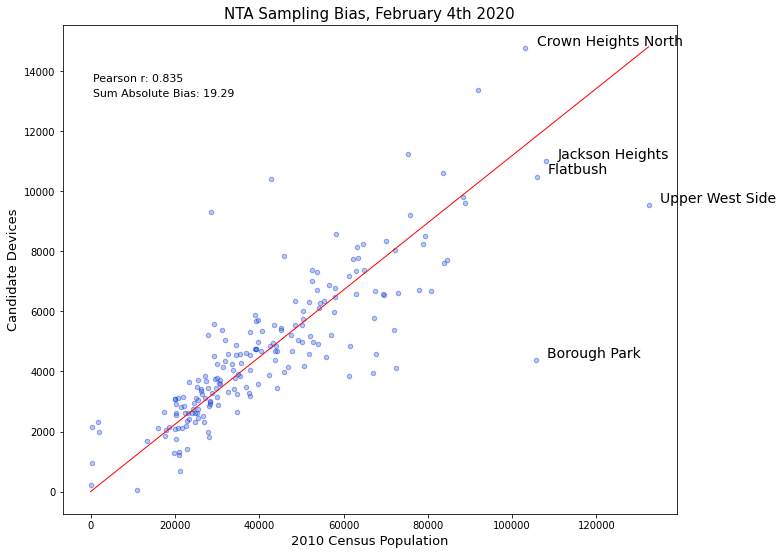

In [153]:
print('NTA-level sampling bias')
alpha_level = 0.35 # point transparency, 35%
ax = plot_sg_vs_geos(df_nta, 'Pop_10E', 'candidate_device_count', num_to_label = 5, text_col = 'name',alpha = alpha_level)
ax.set_title('NTA Sampling Bias, February 4th 2020', color = 'k',  fontsize = 15)
ax.set_xlabel(xlabel = '2010 Census Population',color = 'k',  fontsize = 13)
ax.set_ylabel(ylabel = 'Candidate Devices', color = 'k',  fontsize = 13)
ax.text(0.05, 0.88, 'Pearson r: 0.835', horizontalalignment='left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 11, color = 'k')
ax.text(0.05, 0.85, 'Sum Absolute Bias: 19.29', horizontalalignment='left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 11, color = 'k')
plt.savefig('NTA_scatter.png')
# there is an 81.2% correlation

PUMA-level sampling bias
pearson r: 0.673
Sum Absolute Bias: 15.67


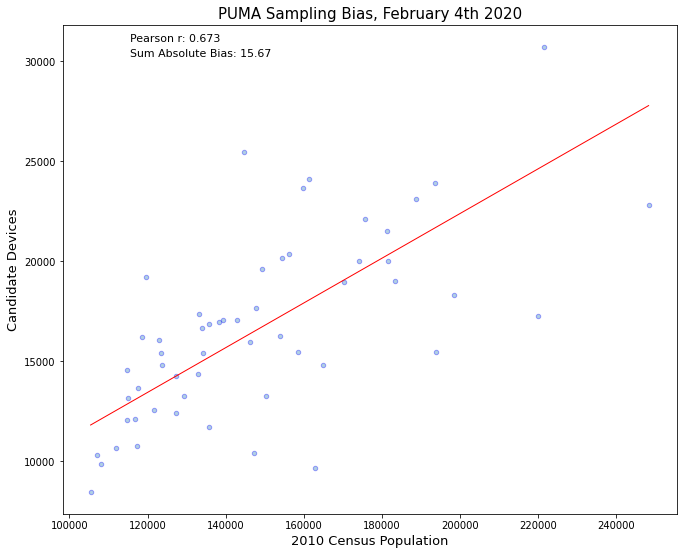

In [27]:
print('PUMA-level sampling bias')
alpha_level = 0.35 # point transparency, 35%
ax2 = plot_sg_vs_geos(df_puma, 'Pop_10E', 'candidate_device_count', num_to_label = 3, text_col = None,alpha = alpha_level)
ax2.set_title('PUMA Sampling Bias, February 4th 2020', color = 'k', fontsize = 15)
ax2.set_xlabel(xlabel = '2010 Census Population',color = 'k',  fontsize = 13)
ax2.set_ylabel(ylabel = 'Candidate Devices', color = 'k', fontsize = 13)
ax2.text(0.05, 0.88, 'Pearson r: 0.673', horizontalalignment='left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 11, color = 'k')
ax2.text(0.05, 0.85, 'Sum Absolute Bias: 15.67', horizontalalignment='left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 11, color = 'k')
plt.savefig('PUMA_scatter.png')
# there is an 67.8% correlation

Boro-level sampling bias
pearson r: 0.994
Sum Absolute Bias: 5.33


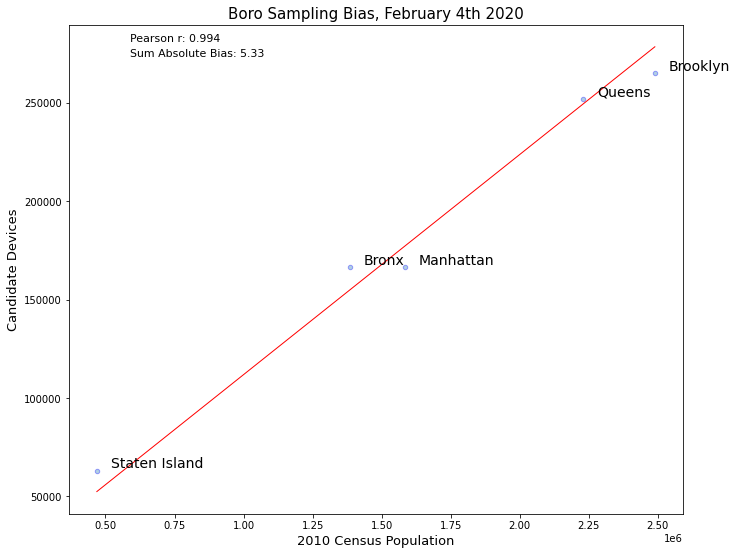

In [171]:
print('Boro-level sampling bias')
alpha_level = 0.35 # point transparency, 35%
ax3 = plot_sg_vs_geos(df_boro, 'Pop_10E', 'candidate_device_count', num_to_label = 5, text_col = 'b_name',alpha = alpha_level)
ax3.set_title('Boro Sampling Bias, February 4th 2020', color = 'k', fontsize = 15)
ax3.set_xlabel(xlabel = '2010 Census Population',color = 'k', fontsize = 13)
ax3.set_ylabel(ylabel = 'Candidate Devices', color = 'k', fontsize = 13)
ax3.text(0.05, 0.88, 'Pearson r: 0.994', horizontalalignment='left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 11, color = 'k')
ax3.text(0.05, 0.85, 'Sum Absolute Bias: 5.33', horizontalalignment='left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 11, color = 'k')
plt.savefig('Boro_scatter.png')
# there is an 99.2% correlation

In [172]:
# save dataframes as csv
# MARCH 3RD, 2020
#df_nta.to_csv('march3_nta.csv', index = False)
#df_puma.to_csv('march3_puma.csv', index = False)
#df_boro.to_csv('march3_boro.csv', index = False)

#February 4TH, 2020
df_nta.to_csv(r'output_csv\feb4_nta.csv', index = False)
df_puma.to_csv(r'output_csv\feb4_puma.csv', index = False)
df_boro.to_csv(r'output_csv\feb4_boro.csv', index = False)
